# Denoising Diffusion Implicit (DDIM) Model Training Pipeline 

## Setup

In [26]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np
from ddim import DiffusionModel

# use which NVIDIA GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


2024-01-06 21:50:22.336756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-06 21:50:22.336915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data pipeline

In [2]:
image_size = 64
batch_size = 32

Found 430 files belonging to 1 classes.
Using 344 files for training.
Using 86 files for validation.


2024-01-06 21:00:10.326580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-06 21:00:10.326598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


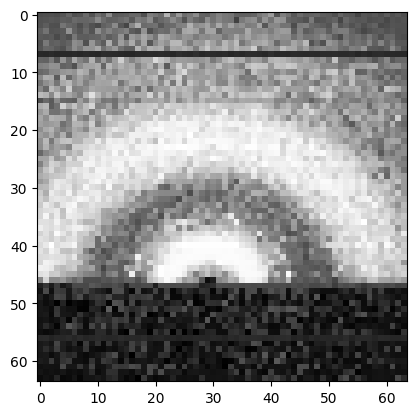

In [3]:
data_dir = './data/dataset'
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                                         labels=None, #if label='inferred', data_dir should be structured
                                                                         color_mode='rgb', #'grayscale',
                                                                         batch_size=batch_size,
                                                                         image_size=(image_size, image_size),
                                                                         shuffle=True,
                                                                         seed=1,
                                                                         validation_split=0.2,
                                                                         subset='both',
                                                                         interpolation='lanczos5')    
    
# convert RGB to 3-channel grayscale to fullfil the diffusion model requirements
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32) 
val_dataset = val_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32)

plt.imshow(next(iter(train_dataset))[1])

## Model Parameters

In [4]:
class ModelParams:
    image_size = image_size
    # KID = Kernel Inception Distance, used for validation step
    kid_image_size = 75
    kid_diffusion_steps = 5  
    plot_diffusion_steps = 10 #diffusion steps, also the denoise steps for prediction

    # scheduler parameters
    min_signal_rate = 0.02
    max_signal_rate = 0.95

    # block parameters
    widths = [32, 64, 96, 128]
    block_depth = 2

    # optimization
    batch_size = batch_size
    ema = 0.999

## Training

In [5]:
num_epochs = 3  # train for at least 50 epochs for good results
learning_rate = 1e-3
weight_decay = 1e-4
checkpoint_path = "checkpoints/diffusion_model"

In [21]:
# create and compile the model
model = DiffusionModel(ModelParams)

model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    #optimizer=keras.optimizers.experimental.SGD(learning_rate=0.1, clipnorm=1.0),
    loss=keras.losses.mean_absolute_error,
)

# save the best model based on the validation KID metric
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)


# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# save log history
txt_log = open('ddim_train_logs.txt', mode='wt', buffering=1)

# run training and plot generated images periodically
# source code: https://github.com/keras-team/keras/blob/master/keras/engine/training.py
# printing training results, then validation 
training= model.fit(
            train_dataset.take(len(train_dataset)-1),  # drop the last batch
            epochs=num_epochs,   
            validation_data=val_dataset.take(len(val_dataset)-1),
            callbacks=[
                #keras.callbacks.LambdaCallback(on_epoch_end=model.plot_rgb_images),
                keras.callbacks.LambdaCallback(
                    on_epoch_end = lambda epoch, logs: txt_log.write(f'epoch: {epoch}\tn_loss: {logs["n_loss"]}\ti_loss: {logs["i_loss"]}\n'),
                    on_train_end = lambda logs: txt_log.close()                
                ),
                checkpoint_callback,
            ],
)

Epoch 1/3
10/10 [==============================] - 33s 2s/step - n_loss: 0.7358 - i_loss: 3.1552 - val_n_loss: 0.7976 - val_i_loss: 2.9298 - val_kid: 1.9115
Epoch 2/3
10/10 [==============================] - 11s 1s/step - n_loss: 0.4563 - i_loss: 1.6315 - val_n_loss: 0.7988 - val_i_loss: 3.4770 - val_kid: 1.9477
Epoch 3/3
10/10 [==============================] - 9s 865ms/step - n_loss: 0.3296 - i_loss: 1.0026 - val_n_loss: 0.7988 - val_i_loss: 3.4770 - val_kid: 1.9579


## Continue training from the saved checkpoint

**Note:** the training process starts with a new optimizer each time. This is because the optimizer states are not saved in the checkpoint.  However, we can observe the loss continue going down as the new training starts.

In [24]:
txt_log = open('ddim_train_logs.txt', mode='rt', buffering=1)
contents = "\n".join(map(lambda s: s.rstrip('\n'), txt_log.readlines()))
txt_log = open('ddim_train_logs.txt', mode='wt', buffering=1)
txt_log.write(contents+'\n')

training2= model.fit(
            train_dataset.take(len(train_dataset)-1),  # drop the last batch
            epochs=num_epochs,   
            validation_data=val_dataset.take(len(val_dataset)-1),
                        callbacks=[
                #keras.callbacks.LambdaCallback(on_epoch_end=model.plot_rgb_images),
                keras.callbacks.LambdaCallback(
                    on_epoch_end = lambda epoch, logs: txt_log.write(f'epoch: {epoch}\tn_loss: {logs["n_loss"]}\ti_loss: {logs["i_loss"]}\n'),
                    on_train_end = lambda logs: txt_log.close()                
                ),
                checkpoint_callback,
            ],
)

Epoch 1/3
10/10 [==============================] - 9s 762ms/step - n_loss: 0.2839 - i_loss: 0.6944 - val_n_loss: 0.7988 - val_i_loss: 3.4769 - val_kid: 1.9703
Epoch 2/3
10/10 [==============================] - 8s 722ms/step - n_loss: 0.2726 - i_loss: 0.6208 - val_n_loss: 0.7988 - val_i_loss: 3.4768 - val_kid: 1.9739
Epoch 3/3
10/10 [==============================] - 8s 723ms/step - n_loss: 0.2641 - i_loss: 0.5720 - val_n_loss: 0.7987 - val_i_loss: 3.4768 - val_kid: 1.9776
